In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from scipy.stats import skew, skewtest
#%config InlineBackend.figure_format = 'png' 
%matplotlib inline

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Skewness of the original intended feature: 1.3291026531678385
Skewness of transformed feature -0.0336566763529419


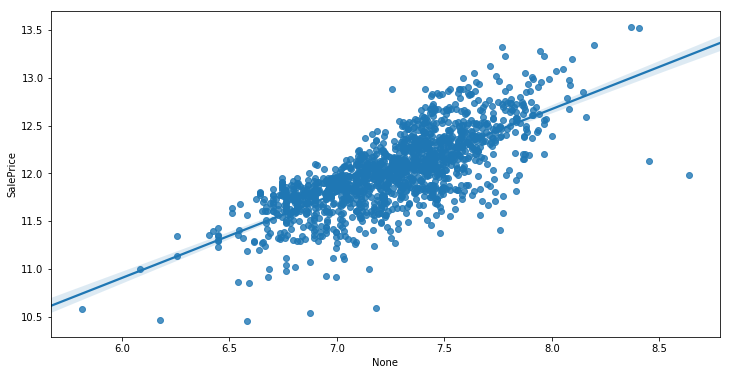

In [5]:
feat_trial = (train['1stFlrSF'] + train['2ndFlrSF']).copy()
print("Skewness of the original intended feature:",skew(feat_trial))
print("Skewness of transformed feature", skew(np.log1p(feat_trial)))

# hence, we'll use the transformed feature thank you very much!
feat_trial = np.log1p(feat_trial)
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

# seaborn's regression plot (I liked it a lot. hence it found it's way here!)
sns.regplot(x=(feat_trial), y=np.log1p(train['SalePrice']), data=train, order=1);

In [6]:
# lets create the feature then
train['1stFlr_2ndFlr_Sf'] = np.log1p(train['1stFlrSF'] + train['2ndFlrSF'])
test['1stFlr_2ndFlr_Sf'] = np.log1p(test['1stFlrSF'] + test['2ndFlrSF'])

Skewness of the original intended feature: 1.427345461344283
Skewness of transformed feature 0.022891569554582734


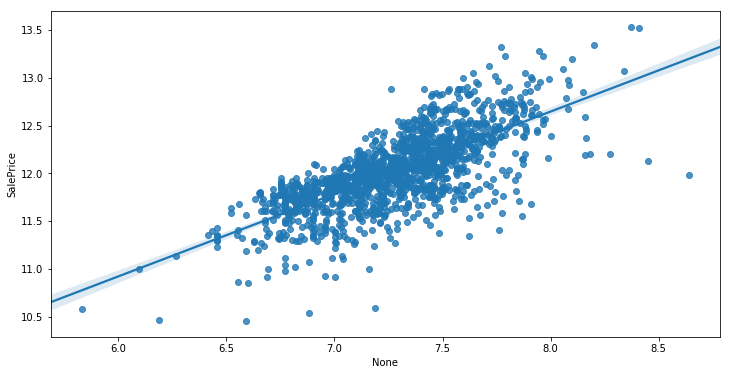

In [7]:
feat_trial = (train['1stFlr_2ndFlr_Sf'] + train['LowQualFinSF'] + train['GrLivArea']).copy()
print("Skewness of the original intended feature:",skew(feat_trial))
print("Skewness of transformed feature", skew(np.log1p(feat_trial)))

# hence, we'll use the transformed feature thank you very much!
feat_trial = np.log1p(feat_trial)
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

# seaborn's regression plot (I liked it a lot. hence it found it's way here!)
sns.regplot(x=(feat_trial), y=np.log1p(train['SalePrice']), data=train, order=1);

In [8]:
train['All_Liv_SF'] = np.log1p(train['1stFlr_2ndFlr_Sf'] + train['LowQualFinSF'] + train['GrLivArea'])
test['All_Liv_SF'] = np.log1p(test['1stFlr_2ndFlr_Sf'] + test['LowQualFinSF'] + test['GrLivArea'])

In [9]:
# get all features except Id and SalePrice
feats = train.columns.difference(['Id','SalePrice'])

# the most hassle free way of working with data is to concatenate them
# since there are many features that contain nan/null values in the test set
# that the train set doesn't
all_data = pd.concat((train.loc[:,feats],
                      test.loc[:,feats]))

In [10]:
# But first, we log transform the target: (reason well explained in Alexandru's AWESOME Notebook)
train["SalePrice"] = np.log1p(train["SalePrice"])

In [11]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [12]:
# getting dummies for all features. You can go the LabelEncoder way, but this method
# is more sound (and easier!!!) in my opinion
all_data = pd.get_dummies(all_data)

In [13]:
# 3. filling NA's with the mean of the column:
all_data = all_data.fillna(all_data[:train.shape[0]].mean())

In [14]:
print(all_data.shape)
# creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

(2919, 290)


In [15]:
# optional. Save these newly created matrices for later usage
# new_test = pd.DataFrame(X_test.copy())
# new_test['Id'] = test['Id'].copy()
# new_test.to_csv("../input/new_test.csv", index=False)

# new_train = pd.DataFrame(X_train.copy())
# new_train['SalePrice'] = y.copy()
# new_train.to_csv("../input/new_train.csv", index=False)

In [16]:
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv=5))
    return(rmse)

In [17]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression

In [18]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], selection='random', max_iter=15000).fit(X_train, y)
res = rmse_cv(model_lasso)
print("Mean:",res.mean())
print("Min: ",res.min())

Mean: 0.123208979347
Min:  0.103575130929


In [19]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 114 variables and eliminated the other 176 variables


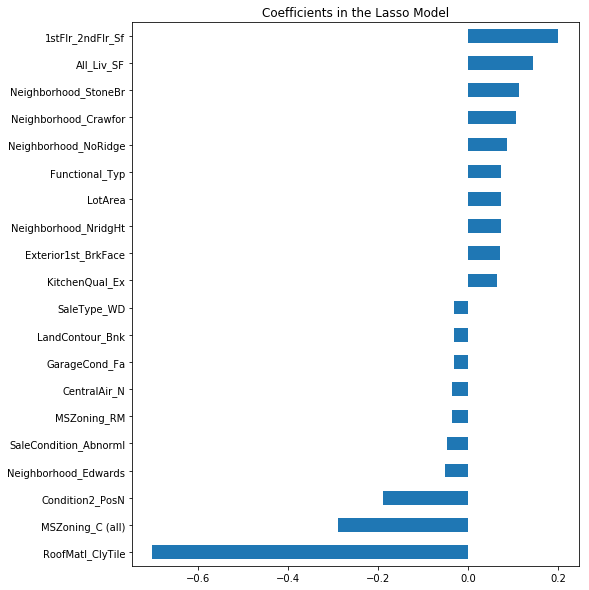

In [20]:
# plotting feature importances!
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [21]:
# Let's make some predictions and submit it to the lb
test_preds = np.expm1(model_lasso.predict(X_test))
submission = pd.DataFrame()
submission['Id'] = test['Id']
submission["SalePrice"] = test_preds
submission.to_csv("lasso_by_Sarthak.csv", index=False)